In [2]:
#Import Library
!pip install catboost
!pip install lightgbm
import time
import math
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sci
import plotly.offline as py
import plotly.graph_objs as go
import random

import lightgbm as lgb
import catboost as cb
import xgboost as xgb


from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import plotly.express as px
from matplotlib import pyplot as plt
import graphviz
plt.style.use('fivethirtyeight')
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [ ]:
data =pd.read_csv('/content/drive/MyDrive/censdataf.csv')
data.set_index('date', inplace = True)
data.index = pd.to_datetime(data.index)

#eliminated feature by feature selection catboost
column=['t2mshan', 'sh850ct', 'sh700ct', 'u700ct', 'vo850ct', 'sktshan', 't2msib', 'u850ct', 'stct', 'rh700ct', 'sktsib', 'dz850sib',
            'sstct', 'mslpsib', 'rh925ct', 'rh850ct', 'z850sib', 'sst', 'vo925ct', 'rh850', 'spsib', 'st', 'u925ct', 'u925', 'sh925ct', 'dmslpsib',
            'dspsib', 'sh850', 'dspct', 'dz925sib', 'sh700', 'dmslpct', 'z925sib']

In [6]:
### Define Label Multi Classification Data

array_nilai=data['cens']
array_kategori = np.where(array_nilai > 5, '0',
                          np.where(array_nilai > 0, '1',
                                   np.where(array_nilai > -5, '2', '3')))
kategori_counts = np.unique(array_kategori, return_counts=True)
data['label'] =array_kategori.astype(int)
data = data.drop('cens', axis=1)
data

,t2m,st,sst,mslp,sp,u10,v10,v925,v850,v700,...,div700ct,dmslpsib,dmslphk,dspsib,dsphk,dmslpct,dspct,dz925sib,dz850sib,label
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,298.64847,299.53120,300.0265,100879.810,100299.000,-5.022632,-4.687611,-5.651194,-1.188097,2.492044,...,-1.560000e-07,3031.680,1490.790,-9008.290,-240.430,280.495,855.350,1264.7310,390.4290,1
2018-01-01 01:00:00,298.81805,299.71527,300.0265,100981.305,100400.520,-5.148923,-4.552235,-5.407810,-1.039129,2.494372,...,2.570000e-07,2987.445,1420.605,-9064.856,-310.800,263.095,837.996,1213.8647,337.6610,1
2018-01-01 02:00:00,299.41770,299.93353,300.0265,101010.700,100430.810,-5.134071,-4.435445,-5.245741,-0.970690,2.413064,...,2.810000e-07,3005.860,1394.220,-9057.400,-334.070,265.640,839.630,1218.3160,340.7900,1
2018-01-01 03:00:00,299.52258,300.05430,300.0265,101009.625,100431.010,-5.001983,-4.350795,-5.139023,-0.944878,2.271676,...,4.270000e-07,3036.365,1341.125,-9030.120,-379.210,246.515,819.240,1238.5366,360.9035,1
2018-01-01 04:00:00,299.58655,300.16965,300.0265,100963.710,100386.490,-4.771851,-4.283898,-5.090341,-1.051479,2.114944,...,7.010000e-07,3068.500,1314.860,-8987.420,-398.380,216.665,788.020,1270.9660,395.6670,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12 15:00:00,301.40033,302.16852,303.0125,100984.445,100405.200,1.412834,2.475831,3.337091,2.184173,0.632958,...,-1.460000e-06,32.719,-426.995,-10513.850,-1905.010,-242.185,331.175,2666.2134,-4549.9370,1
2023-06-12 16:00:00,301.32437,302.14108,303.0125,101007.640,100428.375,1.484044,2.330457,3.155108,2.025348,0.540446,...,-1.540000e-06,17.950,-474.880,-10541.359,-1953.295,-267.940,305.385,2647.7027,-4566.6920,1
2023-06-12 17:00:00,301.19110,302.11713,303.0125,100964.930,100385.820,1.602317,2.202839,2.994151,1.873852,0.447060,...,-1.910000e-06,66.320,-455.125,-10505.120,-1934.080,-267.890,305.266,2686.6160,-4525.4750,1


In [17]:
#find out amount of each label
def count_cens(data, num):
    count = 0
    for number in data:
        count += str(number).count(f'{num}')
    return count

# Example calculating amount label number 3
number_3 = count_cens(data['label'],3)
print("amount label of 3:", number_3)

amount label of 3: 1633


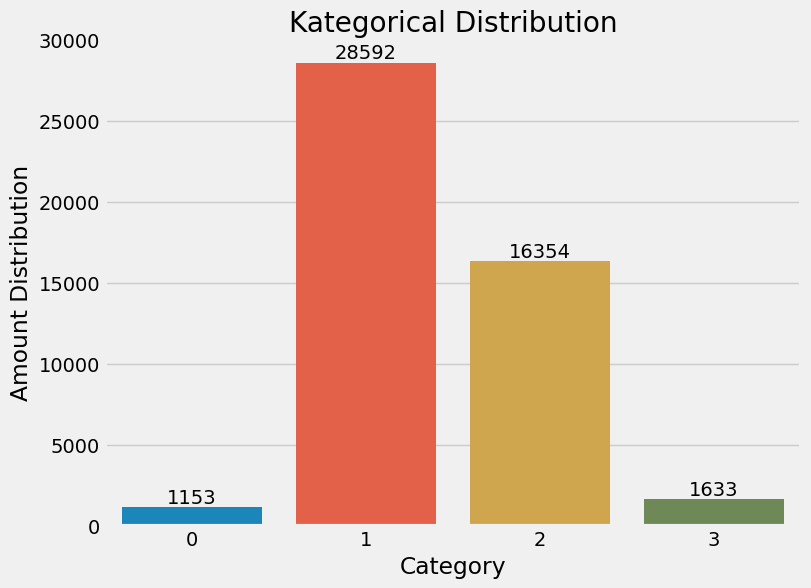

In [20]:
# plot histogram
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=np.squeeze(data['label']),data=data,order=[0,1,2,3])
plt.xlabel('Category')
plt.ylabel('Amount Distribution')
plt.title('Kategorical Distribution')
cat_counts = np.unique(np.squeeze(data['label']), return_counts=True)
# Display
for i, count in enumerate(cat_counts[1]):
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.show()

In [23]:
train_size = int(0.8 * len(data))

# Split training & test
y_train = data['label'][:train_size]
X_train = data.drop('label',axis=1)[:train_size]
y_test = data['label'][train_size:]
X_test = data.drop('label',axis=1)[train_size:]

"""code for shuffle train data"""
#train_data = np.column_stack((X_train, y_train))
#np.random.shuffle(train_data)
#X_train = train_data[:, :-1]
#y_train = train_data[:, -1]

print("Shape Data Train:", X_train.shape)

Shape Data Train: (38185, 74)


In [25]:
# Model LightGBM
lgb_params={'n_estimators': 2822, 'max_depth': 2, 'learning_rate': 0.07289267457871532, 'subsample': 0.8362101731189066, 'reg_alpha': 0.5294708841147577, 'reg_lambda': 0.8180626444557617, 'colsample_bytree': 0.572137249155041, 'min_child_samples': 20}
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of data points in the train set: 38185, number of used features: 74
[LightGBM] [Info] Start training from score -3.567335
[LightGBM] [Info] Start training from score -0.528350
[LightGBM] [Info] Start training from score -1.050552
[LightGBM] [Info] Start training from score -3.428138


LGBMClassifier()

In [26]:
# Model CatBoost
cb_params= {'n_estimators': 1658, 'max_depth': 4, 'learning_rate': 0.045945414297864126, 'rsm': 0.9108350526657705, 'reg_lambda': 0.7568165553426711, 'random_strength': 10}
cb_model = cb.CatBoostClassifier()
cb_model.fit(X_train, y_train, verbose=False)

In [27]:
# Model XGBoost
xgb_params={'n_estimators': 2713, 'max_depth': 5, 'learning_rate': 0.008811585627593823, 'subsample': 0.5307165045453816, 'reg_alpha': 0.9587814870429702, 'reg_lambda': 0.34306966334630296, 'gamma': 0.18869787682536276, 'min_child_weight': 8}
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [28]:
# Prediksi dengan model LightGBM
lgb_predictions = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, lgb_predictions)
lgb_confusion = confusion_matrix(y_test, lgb_predictions)
lgb_class = classification_report(y_test, lgb_predictions)
print("accuracy score LightGBM:", lgb_accuracy)
print(lgb_class)

# Prediksi dengan model CatBoost
cb_predictions = cb_model.predict(X_test)
cb_accuracy = accuracy_score(y_test, cb_predictions)
cb_confusion = confusion_matrix(y_test, cb_predictions)
cb_f1 = classification_report(y_test, cb_predictions)
print("accuracy score CatBoost:", cb_accuracy)
print(cb_f1)

# Prediksi dengan model XGBoost
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_confusion = confusion_matrix(y_test, xgb_predictions)
xgb_f1 = classification_report(y_test, xgb_predictions)
print("accuracy score XGBoost:", xgb_accuracy)
print(xgb_f1)

accuracy score LightGBM: 0.8039174609825076
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.85      0.92      0.88      6079
           2       0.72      0.66      0.69      2999
           3       0.59      0.30      0.40       394

    accuracy                           0.80      9547
   macro avg       0.54      0.47      0.49      9547
weighted avg       0.79      0.80      0.79      9547

accuracy score CatBoost: 0.8041269508746203
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.85      0.92      0.88      6079
           2       0.72      0.67      0.69      2999
           3       0.65      0.27      0.38       394

    accuracy                           0.80      9547
   macro avg       0.55      0.46      0.49      9547
weighted avg       0.79      0.80      0.79      9547

accuracy score XGBoost: 0.8074787891484236

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



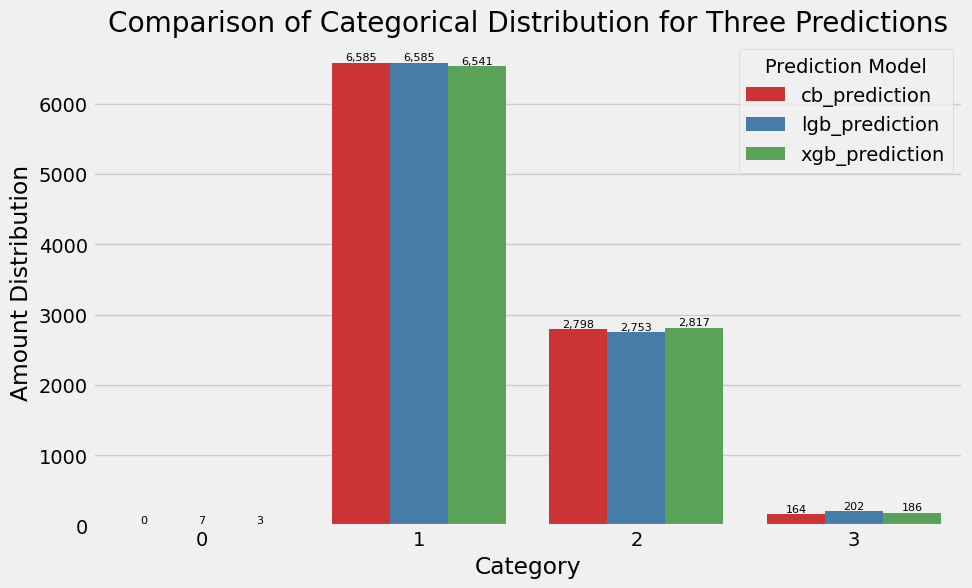

In [39]:
# compare 3 model distribution
data_plot = pd.DataFrame({
    'cb_prediction': cb_predictions.flatten(),
    'lgb_prediction': lgb_predictions.flatten(),
    'xgb_prediction': xgb_predictions.flatten()
})

# combine data
merged_data = pd.melt(data_plot, value_vars=['cb_prediction', 'lgb_prediction', 'xgb_prediction'])

# Plot histogram
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='value', data=merged_data, order=[0, 1, 2, 3], hue='variable', palette='Set1')

plt.xlabel('Category')
plt.ylabel('Amount Distribution')
plt.title('Comparison of Categorical Distribution for Three Predictions')
plt.legend(title='Prediction Model', loc='upper right')

# Annotate each bar with the count
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8)
plt.show()

In [30]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import roc_curve,roc_auc_score,auc
def plot_roc_curve(y_test, y_pred):

    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes))
    #y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

  # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
    plt.figure(figsize=(10,8))
#    plt.figure(dpi=300)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
             color="pink", linestyle="-.", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
             label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
             color="purple", linestyle="-.", linewidth=4,)

    colors = cycle(["gray", "green", "blue", "yellow", "red",'black','brown','goldenrod','gold',
                    'aqua','violet','darkslategray','mistyrose','darkorange','tan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, linestyle="--",
                 label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) curve")
    plt.legend()

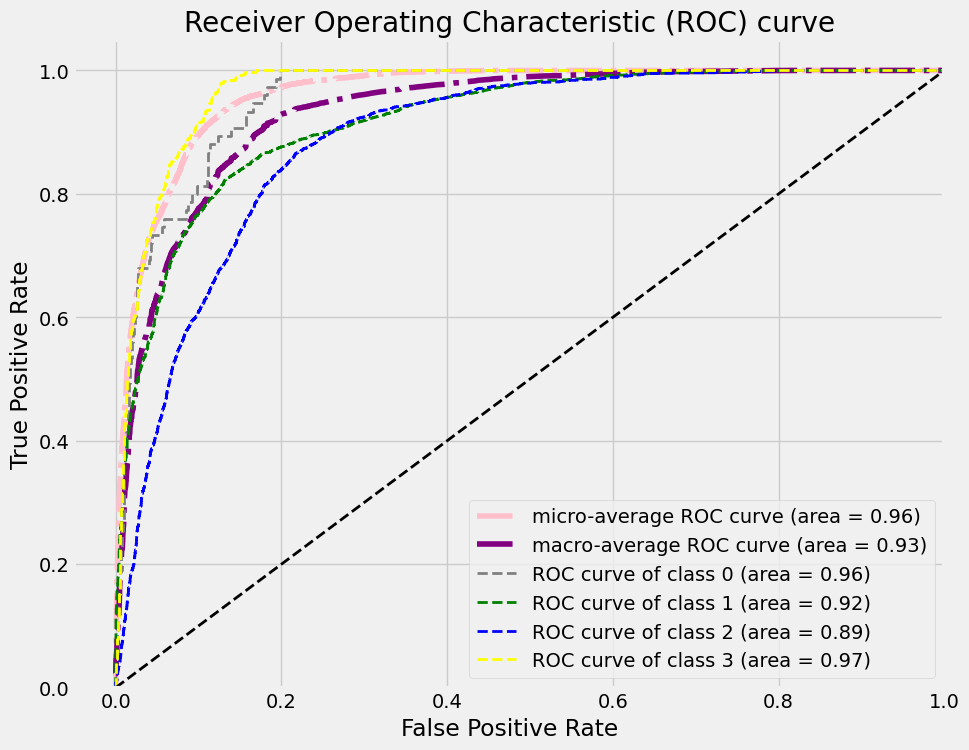

In [31]:
dfc = pd.DataFrame(data=y_test)
yv=dfc.iloc[:,0]

dfc_va2 = cb_model.predict(X_test)
dfc_va= cb_model.predict_proba(X_test)
#Print model report:
#ROC CatBoost
plot_roc_curve(yv, dfc_va)

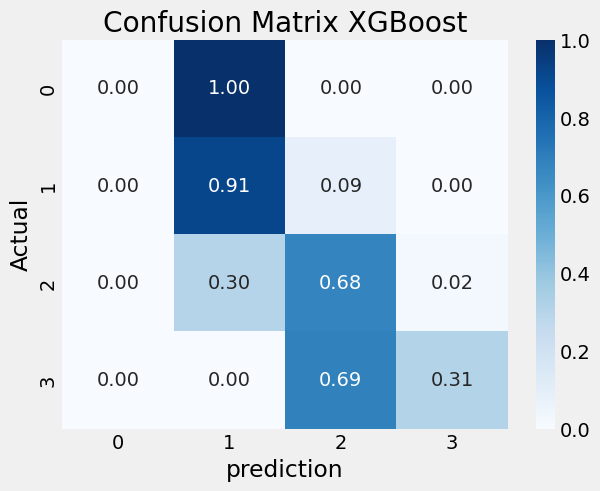

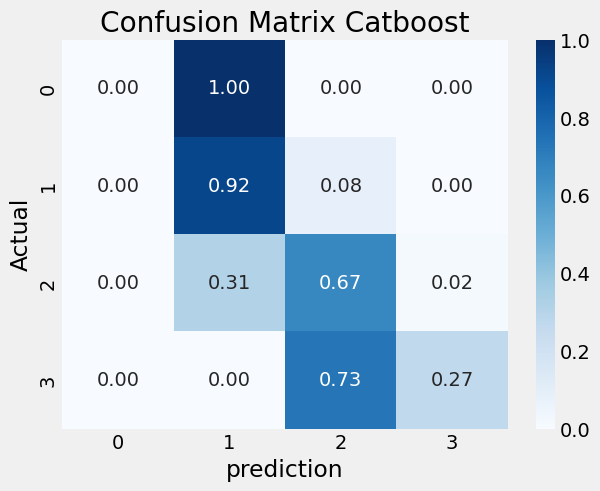

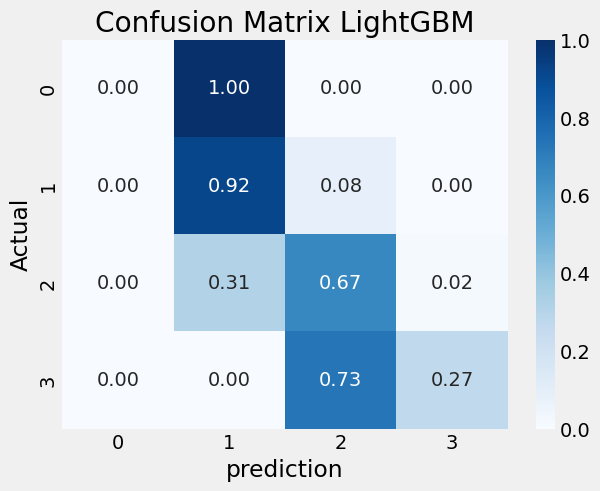

In [32]:
# Normalize Confussion Matrix
xgb_confusion = confusion_matrix(y_test,xgb_predictions)
cm_percent = xgb_confusion.astype('float') / xgb_confusion.sum(axis=1)[:, np.newaxis]

# Plot Confussion Matrix
plt.figure()
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt=".2f")
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix XGBoost')
plt.show()

cb_confusion = confusion_matrix(y_test,cb_predictions)
cm_percent1 = cb_confusion.astype('float') / cb_confusion.sum(axis=1)[:, np.newaxis]

# Plot Confussion Matrix
plt.figure()
sns.heatmap(cm_percent1, annot=True, cmap='Blues', fmt=".2f")
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix Catboost')
plt.show()

lgb_confusion = confusion_matrix(y_test,cb_predictions)
cm_percent2 = lgb_confusion.astype('float') / lgb_confusion.sum(axis=1)[:, np.newaxis]

# Plot Confussion Matrix
plt.figure()
sns.heatmap(cm_percent2, annot=True, cmap='Blues', fmt=".2f")
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix LightGBM')
plt.show()

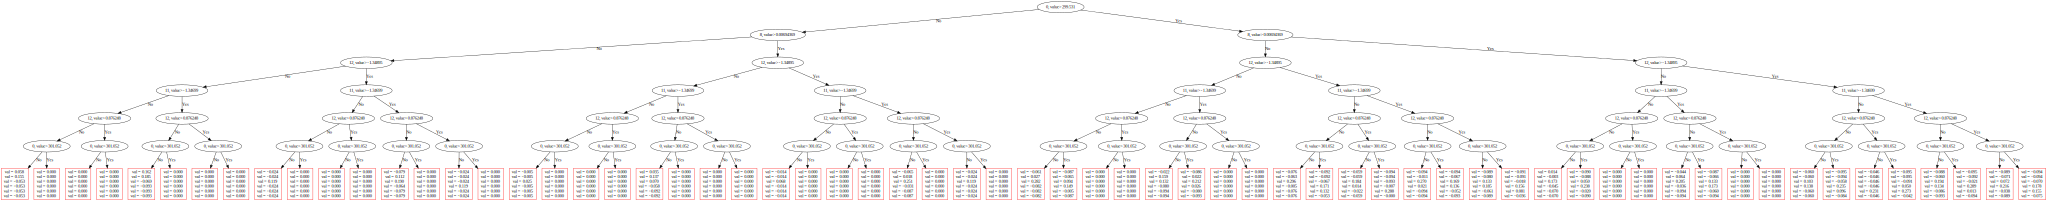

In [ ]:
cb_model.plot_tree(tree_idx=0)